In [1]:
# Name: Changjun Zai
# ID: 1127473900
# Email: czai@usc.edu
# Date: April 14, 2022

In [2]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
NOISE_RATE = 0.4

In [4]:
def build_uniform_P(size, noise):
    """ The noise matrix flips any class to any other with probability
    noise / (#class - 1).
    Randomly map a label to another label
    """
    assert(noise >= 0.) and (noise <= 1.)
    P = np.float64(noise) / np.float64(size - 1) * np.ones((size, size))
    np.fill_diagonal(P, (np.float64(1)-np.float64(noise))*np.ones(size))

    diag_idx = np.arange(size)
    P[diag_idx,diag_idx] = P[diag_idx,diag_idx] + 1.0 - P.sum(0)
    np.testing.assert_array_almost_equal(P.sum(axis=1), 1, 1)
    return P

def build_pair_p(size, noise):
    # Mapping with an alternative distribution function
    assert(noise >= 0.) and (noise <= 1.)
    P = (1.0 - np.float64(noise)) * np.eye(size)
    for i in range(size):
        P[i,i-1] = np.float64(noise)
    np.testing.assert_array_almost_equal(P.sum(axis=1), 1, 1)
    return P

def multiclass_noisify(y, P, random_state=0):
    """ Flip classes according to transition probability matrix T.
    It expects a number between 0 and the number of classes - 1.

    Multi-label hybrid mapping, based on transformation matrix implementation
    """

    assert P.shape[0] == P.shape[1]
    assert np.max(y) < P.shape[0]

    # row stochastic matrix
    np.testing.assert_array_almost_equal(P.sum(axis=1), np.ones(P.shape[1]))
    assert (P >= 0.0).all()

    m = y.shape[0]
    new_y = y.copy()
    flipper = np.random.RandomState(random_state)

    for idx in np.arange(m):
        i = y[idx]
        # draw a vector with only an 1
        flipped = flipper.multinomial(1, P[i, :].flatten(), 1)[0]
        new_y[idx] = np.where(flipped == 1)[0]

    return new_y

def noisify_with_P(y_train, nb_classes, noise, random_state=None, noise_type='uniform'):
    # Set probability P for label mapping
    if noise > 0.0:
        if noise_type=='uniform':
            # print('Uniform noise')
            P = build_uniform_P(nb_classes, noise)
        elif noise_type == 'pair':
            # print('Pair noise')
            P = build_pair_p(nb_classes, noise)
        # else:
            # print('Noise type have implemented')
        #seed the random numbers with #run
        y_train_noisy = multiclass_noisify(y_train, P=P,random_state=random_state)
        actual_noise = (y_train_noisy != y_train).mean()
        assert actual_noise > 0.0
        # print('Actual noise %.2f' % actual_noise)
        y_train = y_train_noisy
    else:
        P = np.eye(nb_classes)

    return y_train, P

In [5]:
# model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

In [6]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training accuracy') 
    ax.plot(valid_losses, color='red', label='Test accuracy')
    ax.set(title="accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [7]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)

        # Constructed label noise
        labels = y_true.detach().numpy()
        train_labels = labels
        noise_rate = NOISE_RATE
        noise_train_labels, P = noisify_with_P(train_labels, 10, noise_rate, 10, 'uniform')
        noise_labels = labels.copy()
        noise_labels = noise_train_labels

        # Count the number of labels with noise
        # count = len(noise_labels) - np.sum(labels == noise_labels)
        # print("Label noise count：", count)
        # print("clear_labels: ", labels)
        # print("noise_labels: ", noise_labels)

        noise_labels = torch.from_numpy(noise_labels)
        y_true = noise_labels

        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [8]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [9]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    n = 1
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accs = []
    test_accs = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Test loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {n+100 * train_acc:.2f}\t'
                  f'Test accuracy: {n+100 * valid_acc:.2f}')
            train_accs.append(n+100 * train_acc)
            test_accs.append(n+100 * valid_acc)

    plot_losses(train_accs, test_accs)
    
    return model, optimizer, (train_losses, valid_losses)

In [10]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [11]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [12]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [13]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

00:24:28 --- Epoch: 0	Train loss: 1.6168	Test loss: 0.7232	Train accuracy: 86.03	Test accuracy: 86.04
00:25:33 --- Epoch: 1	Train loss: 1.4249	Test loss: 0.6310	Train accuracy: 90.77	Test accuracy: 90.78
00:26:33 --- Epoch: 2	Train loss: 1.3829	Test loss: 0.6004	Train accuracy: 91.90	Test accuracy: 91.94
00:27:31 --- Epoch: 3	Train loss: 1.3566	Test loss: 0.5266	Train accuracy: 93.84	Test accuracy: 93.66
00:28:29 --- Epoch: 4	Train loss: 1.3368	Test loss: 0.5344	Train accuracy: 93.93	Test accuracy: 93.81
00:29:27 --- Epoch: 5	Train loss: 1.3305	Test loss: 0.5108	Train accuracy: 95.17	Test accuracy: 95.18
00:30:24 --- Epoch: 6	Train loss: 1.3202	Test loss: 0.5067	Train accuracy: 95.86	Test accuracy: 95.78
00:31:23 --- Epoch: 7	Train loss: 1.3121	Test loss: 0.4943	Train accuracy: 95.88	Test accuracy: 95.93
00:32:21 --- Epoch: 8	Train loss: 1.3055	Test loss: 0.4929	Train accuracy: 95.69	Test accuracy: 95.48
00:33:18 --- Epoch: 9	Train loss: 1.3030	Test loss: 0.4739	Train accuracy: 96.41	T

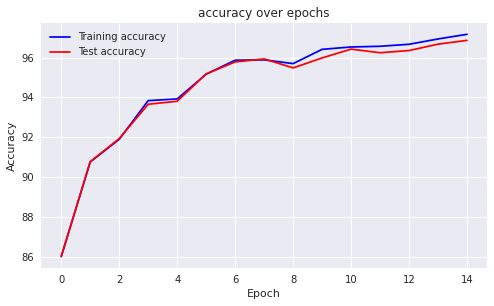

In [14]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

In [15]:
error_e = 0.4

noise_matrix = (1-error_e)*np.mat(np.identity(10))

for i in range(0,9):
  for j in range(0,9):
    if i != j:
      noise_matrix[i,j] = noise_matrix[i,j] + error_e/2

In [16]:
noise_matrix

matrix([[0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. ],
        [0.2, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. ],
        [0.2, 0.2, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. ],
        [0.2, 0.2, 0.2, 0.6, 0.2, 0.2, 0.2, 0.2, 0.2, 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.6, 0.2, 0.2, 0.2, 0.2, 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.6, 0.2, 0.2, 0.2, 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.6, 0.2, 0.2, 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.6, 0.2, 0. ],
        [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.6, 0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.6]])